In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
import sklearn
from sklearn import model_selection
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
from cycler import cycler

# Update matplotlib defaults to something nicer
mpl_update = {
    'font.size': 16,
    'axes.prop_cycle': cycler('color', ['#0085ca', '#888b8d', '#00c389', '#f4364c', '#e56db1']),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.figsize': [12.0, 8.0],
    'axes.labelsize': 20,
    'axes.labelcolor': '#677385',
    'axes.titlesize': 20,
    'lines.color': '#0055A7',
    'lines.linewidth': 3,
    'text.color': '#677385',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Tahoma'
}
mpl.rcParams.update(mpl_update)

## Reading data and Cleaning

In [2]:
base = pd.read_csv("game-of-thrones/character-deaths.csv")
base.head()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0
1,Aegon Frey (Jinglebell),House Frey,299.0,3.0,51.0,49.0,1,1,0,0,1,0,0
2,Aegon Targaryen,House Targaryen,NaN,NaN,NaN,5.0,1,1,0,0,0,0,1
3,Adrack Humble,House Greyjoy,300.0,5.0,20.0,20.0,1,1,0,0,0,0,1
4,Aemon Costayne,Lannister,NaN,NaN,NaN,NaN,1,1,0,0,1,0,0


In [3]:
base['book_intro'] = np.where(base['GoT']==1,1,
                              np.where(base['CoK']==1,2,
                                      np.where(base['SoS']==1,3,
                                              np.where(base['FfC']==1,4,5))))

In [4]:
def fill_death_chapter(row, book_chapter): 
#If book of death is known and chapter of death is not, assume character died in the middle of the book
    if pd.notna(row['Book of Death']) and pd.isna(row['Death Chapter']):
        return book_chapter[row['Book of Death']]/2
    else:
        return row['Death Chapter']

In [5]:
def fill_intro_chapter(row, book_chapter):
#If book of intro is known and chapter of intro is not, assume character was introduced in the middle of the book
    if pd.notna(row['book_intro']) and pd.isna(row['Book Intro Chapter']):
        return book_chapter[row['book_intro']]/2
    else:
        return row['Book Intro Chapter']

In [6]:
book_chapter = {1:72, 2:69, 3:80, 4:45, 5:71}
base['Death Chapter'] = base.apply(fill_death_chapter, book_chapter=book_chapter, axis=1)
base['Book Intro Chapter'] = base.apply(fill_intro_chapter, book_chapter=book_chapter, axis=1)
base.head()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,book_intro
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0,1
1,Aegon Frey (Jinglebell),House Frey,299.0,3.0,51.0,49.0,1,1,0,0,1,0,0,3
2,Aegon Targaryen,House Targaryen,NaN,NaN,NaN,5.0,1,1,0,0,0,0,1,5
3,Adrack Humble,House Greyjoy,300.0,5.0,20.0,20.0,1,1,0,0,0,0,1,5
4,Aemon Costayne,Lannister,NaN,NaN,NaN,40.0,1,1,0,0,1,0,0,3


## Dependent Variable

In [7]:
def book_survival(row,bookno):
    if row['book_intro']==row['Book of Death']==bookno:
        val = row['Death Chapter'] - row['Book Intro Chapter']
    elif row['book_intro']==bookno:
        val = book_chapter[bookno] - row['Book Intro Chapter']
    elif row['book_intro']<bookno and (row['Book of Death']>bookno or pd.isna(row['Book of Death'])):
        val = book_chapter[bookno]
    elif row['Book of Death']==bookno:
        val = row['Death Chapter']
    else:
        val = 0
    return val

In [8]:
base['GoT_chapters'] = base.apply(book_survival,args=(1.0,), axis=1)
base['CoK_chapters'] = base.apply(book_survival,args=(2.0,), axis=1)
base['SoS_chapters'] = base.apply(book_survival,args=(3.0,), axis=1)
base['FfC_chapters'] = base.apply(book_survival,args=(4.0,), axis=1)
base['DwD_chapters'] = base.apply(book_survival,args=(5.0,), axis=1)

In [9]:
base['chapters_survived'] = base['GoT_chapters']+base['CoK_chapters']+base['SoS_chapters']+base['FfC_chapters']+base['DwD_chapters']
base.head()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,book_intro,GoT_chapters,CoK_chapters,SoS_chapters,FfC_chapters,DwD_chapters,chapters_survived
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0,1,16.0,69.0,80.0,45.0,71.0,281.0
1,Aegon Frey (Jinglebell),House Frey,299.0,3.0,51.0,49.0,1,1,0,0,1,0,0,3,0.0,0.0,2.0,0.0,0.0,2.0
2,Aegon Targaryen,House Targaryen,NaN,NaN,NaN,5.0,1,1,0,0,0,0,1,5,0.0,0.0,0.0,0.0,66.0,66.0
3,Adrack Humble,House Greyjoy,300.0,5.0,20.0,20.0,1,1,0,0,0,0,1,5,0.0,0.0,0.0,0.0,0.0,0.0
4,Aemon Costayne,Lannister,NaN,NaN,NaN,40.0,1,1,0,0,1,0,0,3,0.0,0.0,40.0,45.0,71.0,156.0


In [10]:
#Negative chapters_survived - data issue
test = base[base['chapters_survived']<0]
test

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,book_intro,GoT_chapters,CoK_chapters,SoS_chapters,FfC_chapters,DwD_chapters,chapters_survived
333,Harmune,Night's Watch,NaN,NaN,NaN,78.0,1,0,0,0,0,0,1,5,0.0,0.0,0.0,0.0,-7.0,-7.0
637,Petyr Frey,House Frey,300.0,3.0,40.0,49.0,1,1,0,0,1,0,0,3,0.0,0.0,-9.0,0.0,0.0,-9.0


In [11]:
#dropped these rows
base = base[base['chapters_survived']>=0]
base.shape

(915, 20)

In [12]:
# Creating Classes
base['survive_class'] = np.where(base['chapters_survived']<=100,'0-100',
                        np.where(base['chapters_survived']<=200,'100-200','gt200'))

In [13]:
df1 = pd.Series(base['survive_class']).value_counts().reset_index().sort_values('index').reset_index(drop=True)
df1.columns = ['survive_class', 'Frequency']
print (df1)

  survive_class  Frequency
0         0-100        391
1       100-200        248
2         gt200        276


In [14]:
base['Allegiances'].unique()

array(['Lannister', 'House Frey', 'House Targaryen', 'House Greyjoy',
       'Baratheon', "Night's Watch", 'None', 'Arryn', 'House Stark',
       'House Tyrell', 'Tyrell', 'Stark', 'House Mormont', 'Greyjoy',
       'House Lannister', 'Martell', 'House Martell', 'Wildling',
       'Targaryen', 'House Arryn', 'House Tully', 'Tully',
       'House Baratheon', 'House Bolton'], dtype=object)

In [15]:
base['Allegiances'] = np.where(base['Allegiances'] == 'Lannister', 'House Lannister', 
                         np.where(base['Allegiances'] == 'Targaryen', 'House Targaryen',
                         np.where(base['Allegiances'] == 'Greyjoy', 'House Greyjoy',
                         np.where(base['Allegiances'] == 'Baratheon', 'House Baratheon',
                         np.where(base['Allegiances'] == 'Arryn', 'House Arryn', 
                         np.where(base['Allegiances'] == 'Tyrell', 'House Tyrell',
                         np.where(base['Allegiances'] == 'Stark', 'House Stark',
                         np.where(base['Allegiances'] == 'Martell', 'House Martell',
                         np.where(base['Allegiances'] == 'Tully', 'House Tully',
                         np.where(base['Allegiances'] == "Night's Watch", 'Nights Watch',
                                  base['Allegiances']))))))))))
base['Allegiances'] = base['Allegiances'].str.replace(" ","")

In [16]:
base['Allegiances'].unique()

array(['HouseLannister', 'HouseFrey', 'HouseTargaryen', 'HouseGreyjoy',
       'HouseBaratheon', 'NightsWatch', 'None', 'HouseArryn',
       'HouseStark', 'HouseTyrell', 'HouseMormont', 'HouseMartell',
       'Wildling', 'HouseTully', 'HouseBolton'], dtype=object)

In [17]:
base['Allegiance'] = np.where(base['Allegiances'] == 'HouseLannister', 'HouseLannister',
                     np.where(base['Allegiances'] == 'HouseBaratheon', 'HouseBaratheon',
                     np.where(base['Allegiances'] == 'HouseStark', 'HouseStark',
                     np.where(base['Allegiances'] == 'HouseTargaryen', 'HouseTargaryen',
                     np.where(base['Allegiances'] == 'NightsWatch', 'NightsWatch',
                     np.where(base['Allegiances'] == 'Wildling', 'Wildling','Others'))))))

In [18]:
base['Allegiance'].unique()

array(['HouseLannister', 'Others', 'HouseTargaryen', 'HouseBaratheon',
       'NightsWatch', 'HouseStark', 'Wildling'], dtype=object)

In [19]:
base.columns

Index(['Name', 'Allegiances', 'Death Year', 'Book of Death', 'Death Chapter',
       'Book Intro Chapter', 'Gender', 'Nobility', 'GoT', 'CoK', 'SoS', 'FfC',
       'DwD', 'book_intro', 'GoT_chapters', 'CoK_chapters', 'SoS_chapters',
       'FfC_chapters', 'DwD_chapters', 'chapters_survived', 'survive_class',
       'Allegiance'],
      dtype='object')

## Features

#### Merging features from character-predictions.csv

In [20]:
char_pred = pd.read_csv("game-of-thrones/character-predictions.csv")
print(char_pred.shape)
char_pred.head()

(1946, 33)


,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


In [21]:
feature = pd.merge(base,
                   char_pred[['name','isMarried','isNoble','boolDeadRelations','isPopular']], 
                    left_on='Name', right_on='name',
                    how='left', sort=False)
print(feature.shape)
feature.head()

(915, 27)


,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,...,FfC_chapters,DwD_chapters,chapters_survived,survive_class,Allegiance,name,isMarried,isNoble,boolDeadRelations,isPopular
0,Addam Marbrand,HouseLannister,NaN,NaN,NaN,56.0,1,1,1,1,...,45.0,71.0,281.0,gt200,HouseLannister,Addam Marbrand,0.0,1.0,0.0,0.0
1,Aegon Frey (Jinglebell),HouseFrey,299.0,3.0,51.0,49.0,1,1,0,0,...,0.0,0.0,2.0,0-100,Others,NaN,NaN,NaN,NaN,NaN
2,Aegon Targaryen,HouseTargaryen,NaN,NaN,NaN,5.0,1,1,0,0,...,0.0,66.0,66.0,0-100,HouseTargaryen,NaN,NaN,NaN,NaN,NaN
3,Adrack Humble,HouseGreyjoy,300.0,5.0,20.0,20.0,1,1,0,0,...,0.0,0.0,0.0,0-100,Others,NaN,NaN,NaN,NaN,NaN
4,Aemon Costayne,HouseLannister,NaN,NaN,NaN,40.0,1,1,0,0,...,45.0,71.0,156.0,100-200,HouseLannister,Aemon Costayne,0.0,0.0,0.0,0.0


In [22]:
# keeping only characters from major houses
feature = feature[feature['Allegiance']!='Others']

In [23]:
df1 = pd.Series(feature['survive_class']).value_counts().reset_index().sort_values('index').reset_index(drop=True)
df1.columns = ['survive_class', 'Frequency']
print (df1)

  survive_class  Frequency
0         0-100        191
1       100-200        109
2         gt200        158


In [24]:
columns = ['Allegiance','Gender','Nobility','boolDeadRelations','isPopular','isMarried']

In [25]:
feature[columns+['survive_class']].isnull().sum()

Allegiance            0
Gender                0
Nobility              0
boolDeadRelations    25
isPopular            25
isMarried            25
survive_class         0
dtype: int64

In [26]:
#Creating the dependent variable class
feature['survive_class_id'], mapping = feature['survive_class'].factorize()
feature.head()

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,...,DwD_chapters,chapters_survived,survive_class,Allegiance,name,isMarried,isNoble,boolDeadRelations,isPopular,survive_class_id
0,Addam Marbrand,HouseLannister,NaN,NaN,NaN,56.0,1,1,1,1,...,71.0,281.0,gt200,HouseLannister,Addam Marbrand,0.0,1.0,0.0,0.0,0
2,Aegon Targaryen,HouseTargaryen,NaN,NaN,NaN,5.0,1,1,0,0,...,66.0,66.0,0-100,HouseTargaryen,NaN,NaN,NaN,NaN,NaN,1
4,Aemon Costayne,HouseLannister,NaN,NaN,NaN,40.0,1,1,0,0,...,71.0,156.0,100-200,HouseLannister,Aemon Costayne,0.0,0.0,0.0,0.0,2
5,Aemon Estermont,HouseBaratheon,NaN,NaN,NaN,34.5,1,1,0,1,...,71.0,230.5,gt200,HouseBaratheon,Aemon Estermont,0.0,1.0,0.0,0.0,0
6,Aemon Targaryen (son of Maekar I),NightsWatch,300.0,4.0,35.0,21.0,1,1,1,0,...,0.0,235.0,gt200,NightsWatch,NaN,NaN,NaN,NaN,NaN,0


In [27]:
print(mapping)
print(feature['survive_class_id'].unique())

Index(['gt200', '0-100', '100-200'], dtype='object')
[0 1 2]


In [28]:
print(feature.shape)
classification_data = feature[columns+['survive_class_id']].replace([np.inf, -np.inf], np.nan).fillna(0)
print(classification_data.shape)

(458, 28)
(458, 7)


## EDA Plots

In [29]:
plot_feat = classification_data[columns]

plot_target = classification_data["survive_class_id"]

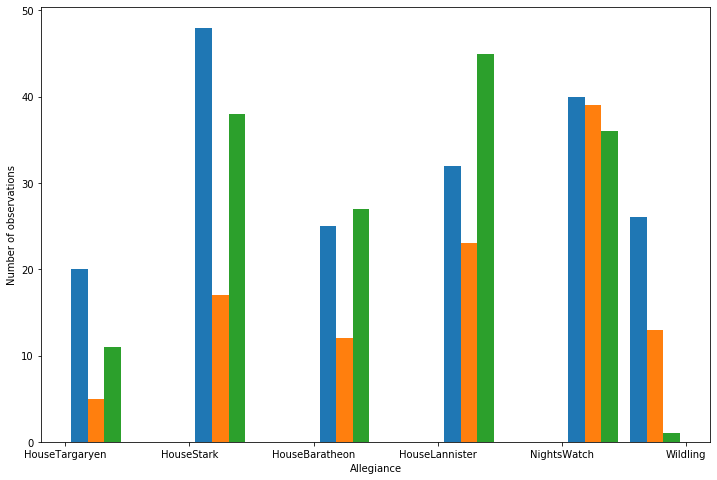

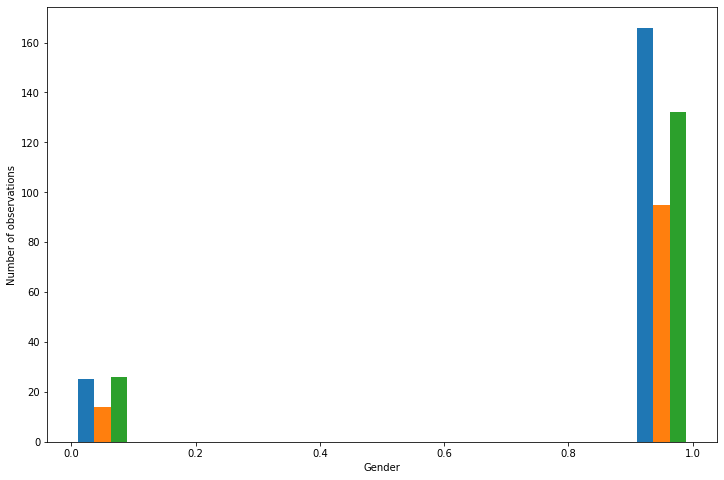

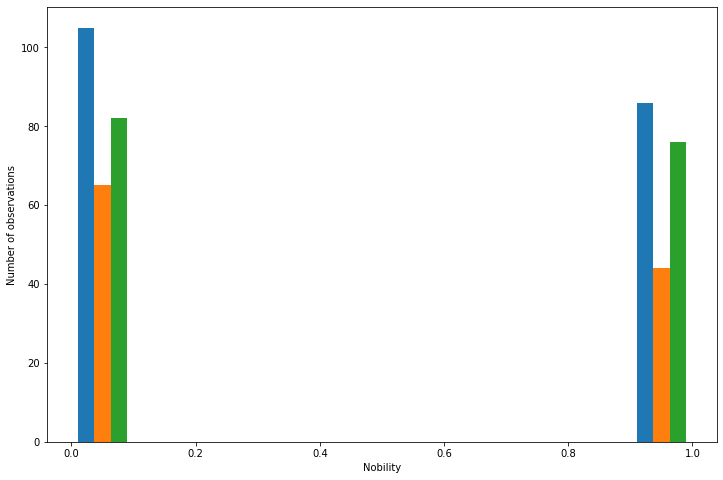

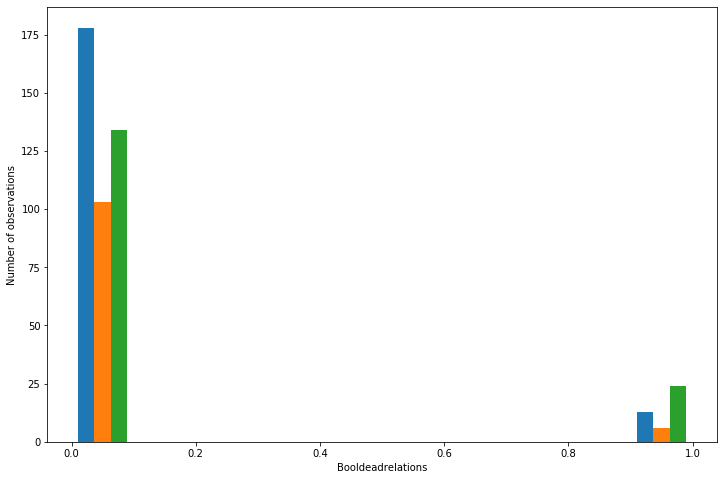

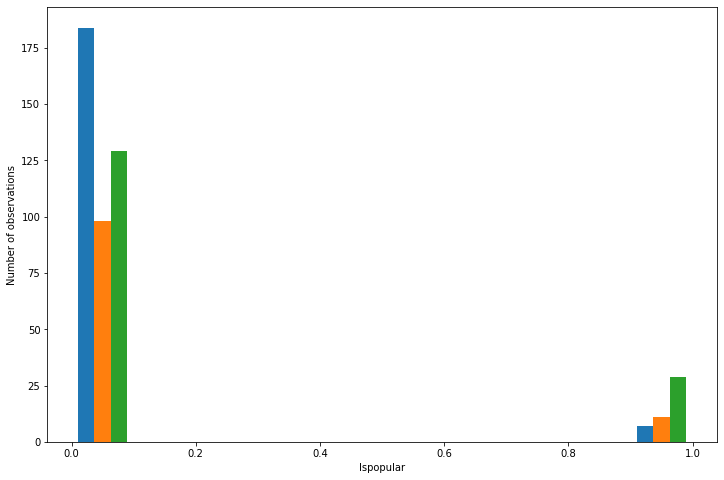

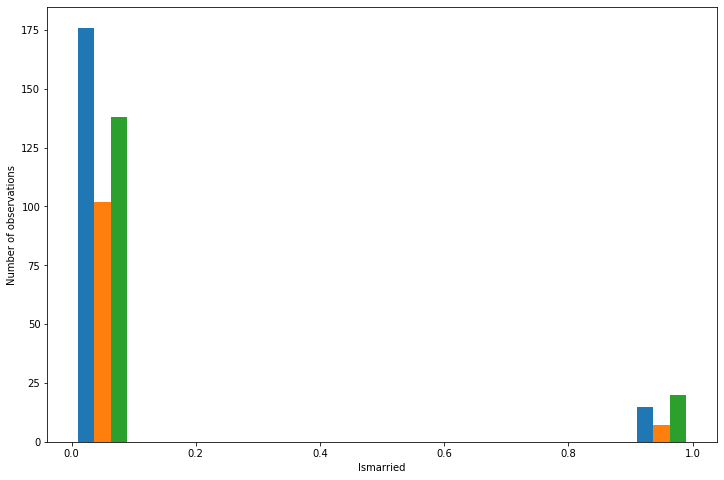

In [30]:
figs = []
for feat in plot_feat.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist([
        plot_feat[plot_target == 1][feat].values, 
        plot_feat[plot_target == 2][feat].values,
        plot_feat[plot_target == 0][feat].values
    ])
    ax.set_xlabel(' '.join(feat.split('_')).capitalize())
    ax.set_ylabel('Number of observations')
    figs.append(fig)

## Model - Classification

In [ ]:
feature = classification_data[columns]

target = classification_data.survive_class_id

In [ ]:
feature.isin([None, np.nan, np.inf, -np.inf]).sum()

In [ ]:
# Convert Allegiances to dummy
dummy = pd.get_dummies(feature['Allegiance'])

feature = pd.concat([feature, dummy], axis=1)

feature.head()

## Model Training

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature, target, 
                                                                    test_size=0.3, random_state=123)

#### Random Forest

In [ ]:
initial_features = ['Gender','Nobility','boolDeadRelations','isPopular','isMarried',
                    'HouseBaratheon', 'HouseLannister', 'HouseStark', 'HouseTargaryen', 
                    'NightsWatch', 'Wildling']

In [ ]:
rf = RandomForestClassifier(n_estimators=10, criterion='entropy', 
                            max_depth=2, max_features=3,
                            random_state=123, class_weight='balanced')

In [ ]:
rf.fit(X_train[initial_features], y_train)

#### Model Performance

In [ ]:
ypred_proba_test = rf.predict_proba(X_test[initial_features])[:,1]
ypred_bin_test = rf.predict(X_test[initial_features])

In [ ]:
df1 = pd.Series(ypred_bin_test).value_counts().reset_index().sort_values('index').reset_index(drop=True)
df1.columns = ['pred_class', 'Frequency']
print (df1)

In [ ]:
#auc = sklearn.metrics.roc_auc_score(y_test, ypred_proba_test)
confusion = sklearn.metrics.confusion_matrix(y_test, ypred_bin_test)
accuracy = sklearn.metrics.accuracy_score(y_test, ypred_bin_test)
#classification_report = sklearn.metrics.classification_report(y_test, ypred_bin_test)

In [ ]:
#print('AUC on test: %0.3f' % auc)
print('Accuracy on test: %0.3f' % accuracy)
print()
print(pd.DataFrame(confusion))

In [ ]:
%load_ext watermark
%watermark -v -m --iversions -g

## Generating data for offline scoring

In [ ]:
initial_features = ['Gender','Nobility','boolDeadRelations','isPopular','isMarried',
                    'HouseBaratheon', 'HouseLannister', 'HouseStark', 'HouseTargaryen', 
                    'NightsWatch', 'Wildling']

In [ ]:
def var_df(var):
    var_df = pd.DataFrame({'key':[1,1], var:[0,1]})
    return var_df

In [ ]:
d = {}
for var in initial_features:
    d[var.replace(" ","")] = var_df(var)

In [ ]:
score_data = d[next(iter(d))]
for var in d.keys():
    if var != next(iter(d)):
        score_data = score_data.merge(d[var], on='key')

In [ ]:
print(score_data.shape)
score_data.head()

In [ ]:
score_data['score'] = rf.predict(score_data[initial_features])

In [ ]:
score_data['prediction'] = mapping.take(score_data['score'])
score_data.head()

In [ ]:
df1 = pd.Series(score_data['prediction']).value_counts().reset_index().sort_values('index').reset_index(drop=True)
df1.columns = ['prediction', 'Frequency']
print (df1)

In [ ]:
df1 = pd.Series(score_data['score']).value_counts().reset_index().sort_values('index').reset_index(drop=True)
df1.columns = ['score', 'Frequency']
print (df1)